<a href="https://colab.research.google.com/github/keinerfan/CIAP_ANN/blob/main/multi_layer_perceptron_for_BICR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# Load the dataset
data = pd.read_csv("CIAP1_and_CIAP2_06_bioactivity_data_3class_pIC50_pubchem_fp.csv")

# Feature selection using VarianceThreshold
from sklearn.feature_selection import VarianceThreshold
selection = VarianceThreshold(threshold=(.8 * (1 - .8)))
merged_data = selection.fit_transform(data)

# Prepare X and y
x = merged_data
y = data.pIC50.values.reshape((-1,1))

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Normalize y using StandardScaler
scaler = StandardScaler()
y_train = scaler.fit_transform(y_train)
y_test = scaler.transform(y_test)

# Convert data to PyTorch tensors
device = torch.device("cpu")
X_train = torch.tensor(X_train, device=device).float()
X_test = torch.tensor(X_test, device=device).float()
y_train = torch.tensor(y_train, device=device).float()
y_test = torch.tensor(y_test, device=device).float()

# Create DataLoader for training
from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=True)


In [5]:

class MLP(nn.Module):
  '''
    Multilayer Perceptron for regression.
  '''
  def __init__(self):
    super().__init__()
    self.layers = nn.Sequential(
      nn.Linear(110, 64),
      nn.ReLU(),
      nn.Linear(64, 32),
      nn.ReLU(),
      nn.Linear(32, 1)
    )


  def forward(self, x):
    '''
      Forward pass
    '''
    return self.layers(x)


In [6]:
 mlp = MLP()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-4)

In [7]:
epochs =1500
losses = []
for i in range (epochs) :
  #go forward
  y_pred = mlp.forward(X_train)
  #measure loss
  loss =  loss_function(y_pred , y_train)
  losses.append(loss.detach().numpy())
  if i % 100 == 0 :
    print(f'epoch:{i} and loss : {loss}')
  #back propagation
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

epoch:0 and loss : 1.0246771574020386
epoch:100 and loss : 0.8183190226554871
epoch:200 and loss : 0.5608576536178589
epoch:300 and loss : 0.32982107996940613
epoch:400 and loss : 0.1951787769794464
epoch:500 and loss : 0.12138726562261581
epoch:600 and loss : 0.0799022987484932
epoch:700 and loss : 0.05728411674499512
epoch:800 and loss : 0.044005073606967926
epoch:900 and loss : 0.03473230078816414
epoch:1000 and loss : 0.027420299127697945
epoch:1100 and loss : 0.02132694236934185
epoch:1200 and loss : 0.01681780442595482
epoch:1300 and loss : 0.013490739278495312
epoch:1400 and loss : 0.010959049686789513


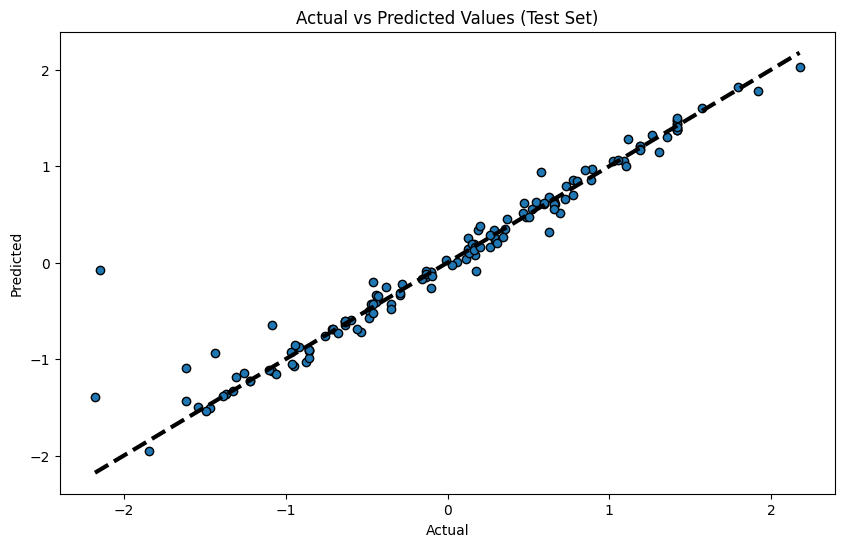

Training Set Metrics:
R-Squared: 0.9909598189271756
Adjusted R-Squared: 0.9887742806458334
Mean Squared Error (MSE): 0.00904018059372902
Mean Absolute Error (MAE): 0.04248681291937828
Mean Absolute Percentage Error (MAPE): 21.203768253326416

Testing Set Metrics:
R-Squared: 0.9457025663371547
Adjusted R-Squared: 0.7530342533399615
Mean Squared Error (MSE): 0.04739917069673538
Mean Absolute Error (MAE): 0.09387914836406708
Mean Absolute Percentage Error (MAPE): 21.4695006608963


In [11]:
#model evaluation
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNet
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
#y_pred_test = mlp(X_test)
#r2_test = r2_score(y_test.detach().numpy(), y_pred_test.detach().numpy())
y_train_pred = mlp(X_train)
y_test_pred = mlp(X_test)
#converting to numpy array
y_train_pred = y_train_pred.detach().numpy()
y_test_pred = y_test_pred.detach().numpy()
# Convert y_train and y_test to numpy arrays to avoid potential issues with pandas Series
y_train = np.array(y_train)
y_test = np.array(y_test)

# Calculate metrics for training set
train_r2 = r2_score(y_train, y_train_pred)
train_mse = mean_squared_error(y_train, y_train_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_mape = np.mean(np.abs((y_train - y_train_pred) / y_train)) * 100

# Adjusted R-Squared for training set
n_train = X_train.shape[0]
p_train = X_train.shape[1]
train_adjusted_r2 = 1 - (1 - train_r2) * (n_train - 1) / (n_train - p_train - 1)

# Calculate metrics for testing set
test_r2 = r2_score(y_test, y_test_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_mape = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100

# Adjusted R-Squared for testing set
n_test = X_test.shape[0]
p_test = X_test.shape[1]
test_adjusted_r2 = 1 - (1 - test_r2) * (n_test - 1) / (n_test - p_test - 1)

# Plot predicted vs real values for test set
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, edgecolors=(0, 0, 0))
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=3)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Values (Test Set)')
plt.show()

# Print metrics for training set
print("Training Set Metrics:")
print(f'R-Squared: {train_r2}')
print(f'Adjusted R-Squared: {train_adjusted_r2}')
print(f'Mean Squared Error (MSE): {train_mse}')
print(f'Mean Absolute Error (MAE): {train_mae}')
print(f'Mean Absolute Percentage Error (MAPE): {train_mape}')

# Print metrics for testing set
print("\nTesting Set Metrics:")
print(f'R-Squared: {test_r2}')
print(f'Adjusted R-Squared: {test_adjusted_r2}')
print(f'Mean Squared Error (MSE): {test_mse}')
print(f'Mean Absolute Error (MAE): {test_mae}')
print(f'Mean Absolute Percentage Error (MAPE): {test_mape}')
